# Лабораторная работа №2. Изучение и освоение методов классификации формы изображений.

Выполнил: Грингауз Александр Дмитриевич, 520 группа.

## Постановка задачи

Дано цветное контрастное изображение ладони на тёмном фоне. Необходимо построить признаковое описание формы ладони в виде "линии пальцев" - ломанной линии, соединяющей кончики пальцев и точки у оснований пальцев.

Пример входного изображения:

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
#%load_ext cython

In [3]:
def show_big_image(I, size=(20,10), cmap=None):
    plt.figure(figsize=size)
    if map is None:
        plt.imshow(I)
    else:
        plt.imshow(I, cmap=cmap)

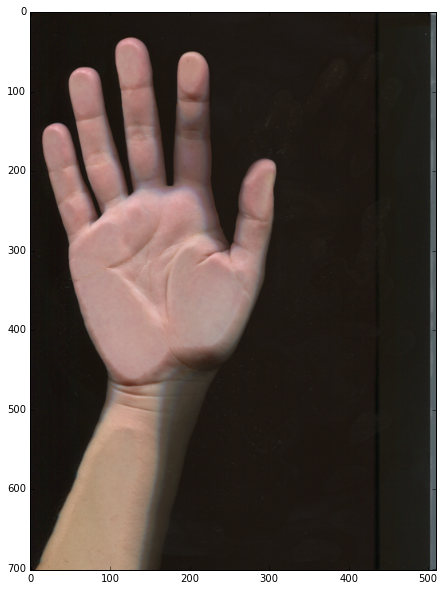

In [4]:
I = cv2.imread("../training/010.tif")
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))

## Информация о реализации

Лабораторная работа была выполнена на языке Python 3.5 + Cython c использованием библиотеки OpenCV 3.

## Методика решения

Сначала выполним бинаризацию изображения и удаление шума:

1. Переведём изображение в оттенки серого.
2. Размоем изображение гауссовым ядром 5х5.
3. Применим пороговую бинаризацию с порогом 60.
4. Применим морфологическое закрытие эллипсом с размером 20х20. Закрытие помогает сгладить границы (они бывают очень неровные) и убрать возможные перемычки между пальцами.
5. Применим стандартную функцию connectedComponentsWithStats для выделения связных компонент и возьмём самую большую по площади.

In [5]:
    def binarize(img):
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        #return cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        #res_image = cv2.threshold(blur, 0, 1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        res_image = cv2.threshold(blur, 60, 1,cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(20,20))
        #res_image = cv2.morphologyEx(res_image, cv2.MORPH_CLOSE, kernel)
        res_image = cv2.morphologyEx(res_image, cv2.MORPH_OPEN, kernel)
        ret, labels, stats, centroids = cv2.connectedComponentsWithStats(res_image, 8, cv2.CV_32S)
        i_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        return (labels == i_component).astype(np.uint8)

(702, 510)


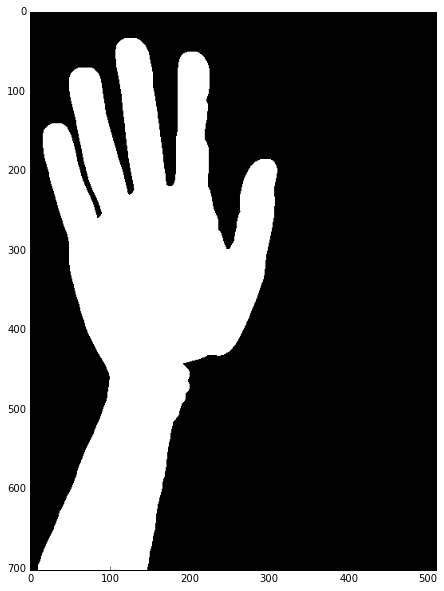

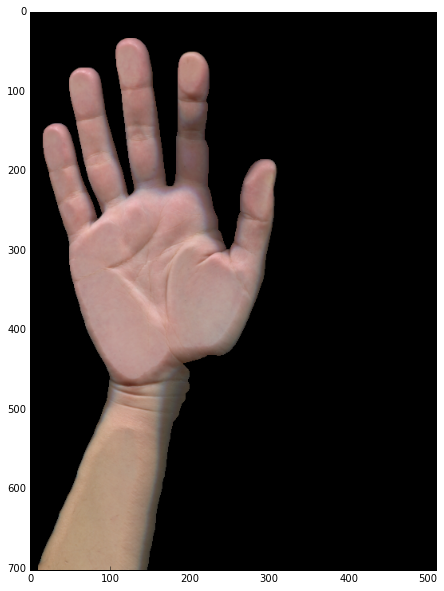

In [6]:
I_b = binarize(I)
print(I_b.shape)
show_big_image(I_b, cmap="gray")
I1 = I.copy()
I1[:, :, 0] *= I_b
I1[:, :, 1] *= I_b
I1[:, :, 2] *= I_b
show_big_image(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))

Далее применим алгоритм Розенфельда (как в лекциях) для нахождения скелета формы. Его реализует класс Skeletonizer. Его код находится в файле skeletonizer.pyx и скомпилирован с помощью Cython в попытке повысить скорость. Однако это не помогло, и алгоритм работает очень долго, около 4-5 минут на кадр. Скорее всего из-за неоптимальной и слишком наивной реализации обработки каждого пикселя на каждой итерации работы алгоритма. Там для каждого пикселя руки проверяется, южный, северный он и т.п., далее смотрим, что он простой, изолированный и концевой. Вероятно, можно придумать реализацию, при которой внутренние пиксели руки зря проверять не нужно.

258.4492070674896


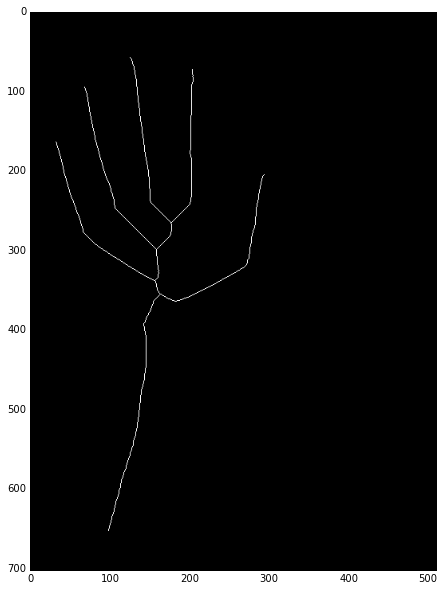

In [7]:
import time
start = time.time()
from skeletonizer import Skeletonizer
skel_obj = Skeletonizer(I_b)
I_skel = skel_obj.find_skeleton()
print(time.time()-start)
show_big_image(I_skel, cmap="gray")

Преобразуем полученное изображение у удобную структуру данных для работы с графом. Это делает класс SkelGraph, который находится в skeletonizer.pyx. Он выполняет обход в глубину. Начинаем обходить граф с какой-нибудь крайней точки, движемся до вершины или до края. Если дошли до вершины, смотрим, куда из неё можно пойти и идём туда. Следим, чтобы не ходить туда, где уже были.

In [16]:
from skeletonizer import SkelGraph

In [17]:
graph = SkelGraph(skel_obj, I_skel)

Визуализируем полученный граф, его вершины показаны красным, центр масс руки - зелёным.

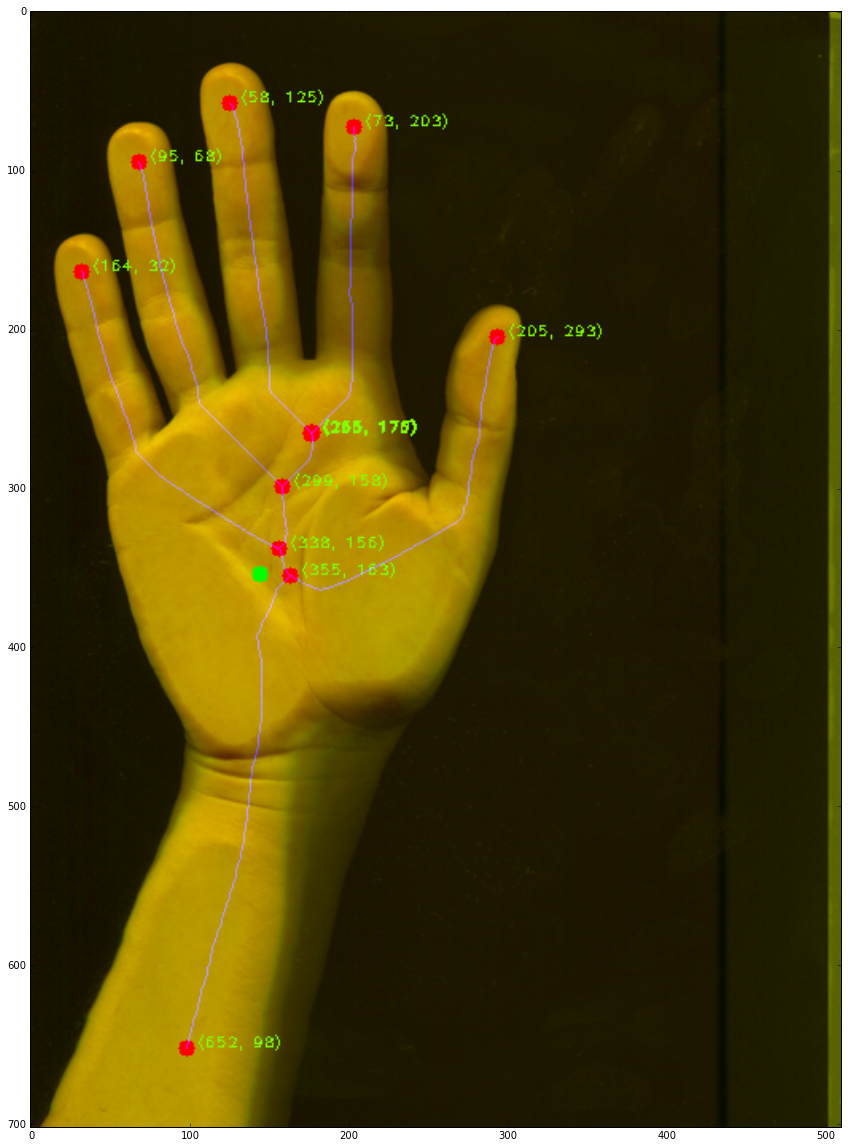

In [19]:
node_image = I.copy()
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(I_b, connectivity=4)
center = (int(centroids[1][0]), int(centroids[1][1]))
cv2.circle(node_image, center, 5, (0,255,0), -1)
for node in graph.nodes:
    cv2.circle(node_image, (node[-1], node[0]), 5, (0,0,255), -1)
    cv2.putText(node_image, str(node), (node[-1] + 7, node[0]), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,255,127), thickness=1)
    
node_image[:,:,0] = I_skel * 255
show_big_image(cv2.cvtColor(node_image, cv2.COLOR_BGR2RGB), size=(40,20))

Далее найдём вершины графа, соответствующие пальцам. Найдём вершины графа степени 1, для этого есть структура graph.degrees. Отфильтруем те из них, пути по графу от которых до ближайших вершин меньше 100, чтобы не учитывать шумные ветви графа.

In [21]:
edges = [key for key, val in graph.degrees.items() if val == 1]
def check_leaf_length(point, l_min=100):
    path = (point, graph.connections[point][0])
    print(path)
    l = None
    if path in graph.lengths:
        l = graph.lengths[path]
    else:
        l = graph.lengths[path[::-1]]
    return l > l_min
edges = list(filter(check_leaf_length, edges))
edges

((652, 98), (355, 163))
((95, 68), (299, 158))
((58, 125), (265, 176))
((205, 293), (355, 163))
((73, 203), (265, 177))
((164, 32), (338, 156))


[(652, 98), (95, 68), (58, 125), (205, 293), (73, 203), (164, 32)]

Посчитаем евклидовы расстояния между полученными концевыми вершинами edges.

In [23]:
import itertools
edge_distances = dict()
for p1, p2 in itertools.combinations(edges, 2):
    edge_distances[(p1, p2)] = np.linalg.norm((p1[0] - p2[0], p1[1] - p2[1]))

Отсортируем пары этих вершин в порядке возрастания расстояний между ними. Далее проитерируемся по полученному массиву и будем добавлять в множество fingers вершины, пока его размер не станет равен 5. Этот эвристический подход для нахождения пальцев основан на предположении, что пальцы соответствуют длинным концевым веткам графа и евклидовое расстояние между вершнинами этих веток должно быть небольшим.

In [27]:
fingers = set()
for p1, p2 in sorted(edge_distances.keys(), key=edge_distances.get):
    if len(fingers) < 5:
        fingers.add(p1)
    else:
        break
    if len(fingers) < 5:
        fingers.add(p2)
    else:
        break

Необходимо определить порядок пальцев (где мизинец, безымянный и т.д.). Для этого, на полученных точках fingers построим выпуклую оболочку на этих точках с помощью функции из OpenCV. Она выдаёт вершины полученного многоугольника в порядке по часовой стрелки.

In [28]:
ordered_fingers = cv2.convexHull(np.array(list(fingers)), clockwise=True).reshape(5,2).tolist()

Найдём пару пальцев, между которыми самое большой расстояние. Это мизинец и большой палец. Исходя из этого формируем массив ordered_fingers_final, который содержит пальцы в порядке от мизинца до большрго.

In [29]:
ordered_fingers.append(ordered_fingers[0])
ordered_fingers

[[58, 125], [73, 203], [205, 293], [164, 32], [95, 68], [58, 125]]

In [30]:
i_big = np.argmax([np.linalg.norm((p1[0] - p2[0], p1[1] - p2[1])) for p1, p2 in zip(ordered_fingers[0:-1], ordered_fingers[1:])])
ordered_fingers_final = ordered_fingers[i_big + 1:-1]
ordered_fingers_final.extend(ordered_fingers[:i_big + 1])
ordered_fingers_final

[[164, 32], [95, 68], [58, 125], [73, 203], [205, 293]]

Далее, найдём точки у оснований пальцев. Для точек между мизинцем, безымянным, средним и указательным алгоритм следующий. Фиксируем отрезок с концами на двух соседних пальцах (точек из ordered_fingers_final). Затем передвигаем концы этого отрезка по путям графа-скелета. На каждом шаге смотрим, есть ли на этом отрезке задний план, если есть, то продолжаем движение, если нет, то останавливаемся, и берём любую точку из отрезка на предыдущей итерации, на которой есть задний план, в качестве искомой.

Для указательного и большого пальца немного другой подход.Также инициализируем отрезок с вершинами на этих пальцах. Затем двигаем вершину из указательного пальца по пути в графе. Вершина в большом пальце остаётся на месте. Аналогичным образом следим за тем, чтобы на отрезке был задний план. Если мы пришли из указательного пальца в смежную вершину графа и на отрезке до сих пор есть задний план, двигаем по графу вершину отрезка из большого пальца. Далее аналогично. Если для указательного и большого пальца применить подход, используемый для других пальцев, то точка часто оказывается на указательном пальце.

Визуализируем полученный результат.

[(254, 89), (229, 126), (219, 175)]
[(254, 89), (229, 126), (219, 175), (298, 246)]


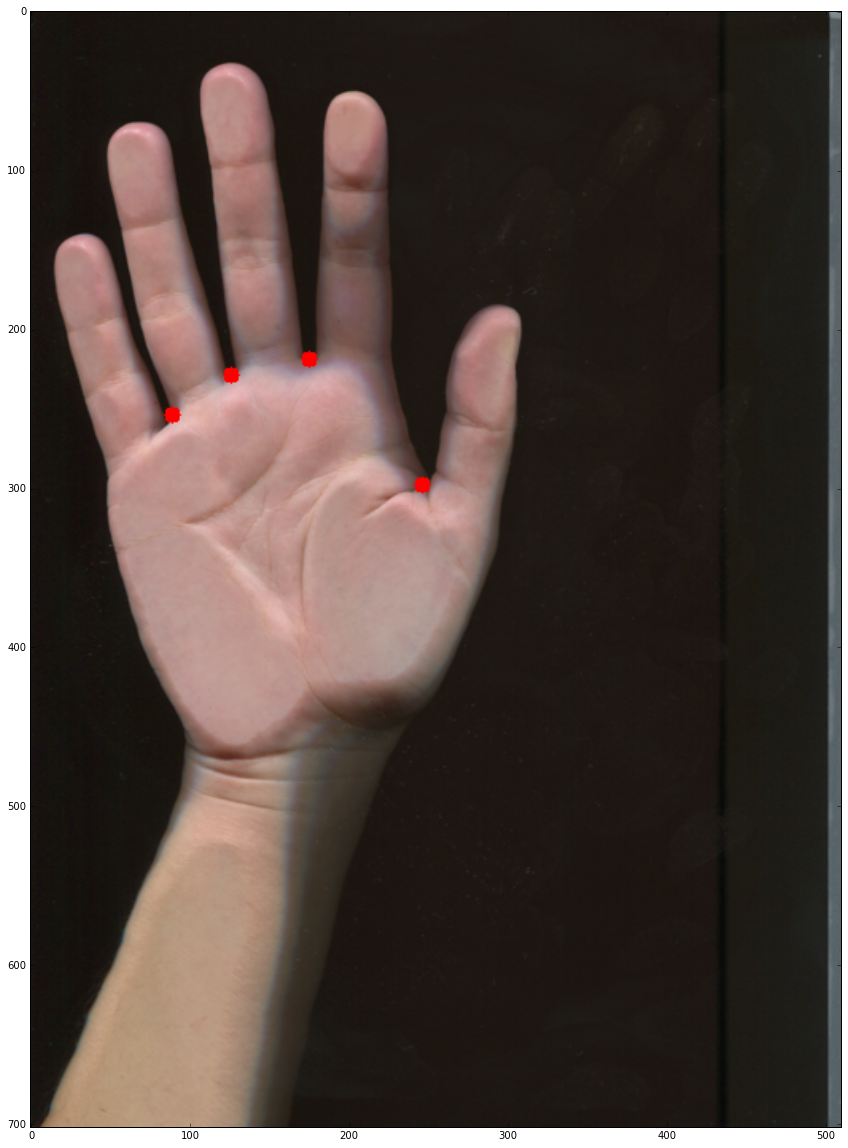

In [32]:
def analyze_finger_line(point1, point2):
    I_tmp = np.zeros(I.shape, dtype=np.uint8)
    cv2.line(I_tmp, point1[::-1], point2[::-1], (1,1,1))
    n_tmp = np.sum(I_tmp[:,:,0])
    I_intersection = I_tmp[:,:,0] * I_b
    n_intersection = np.sum(I_intersection)
    if (n_intersection == n_tmp):
        return None
    else:
        I_diff = I_tmp[:,:,0] - I_intersection
        nz = np.nonzero(I_diff)
        return (nz[0][-1], nz[1][-1])
            
I_valleys = I.copy()
valleys = []
for p1, p2 in zip(ordered_fingers_final[0:-2], ordered_fingers_final[1:-1]):
    path1 = graph.get_path(tuple(p1), graph.connections[tuple(p1)][0])
    path2 = graph.get_path(tuple(p2), graph.connections[tuple(p2)][0])
    result = None
    i_last = 0
    while True:
        point1 = path1[i_last]
        point2 = path2[i_last]
        res = analyze_finger_line(point1, point2)
        if res is None:
            break
        else:
            i_last += 1
            result = res
            
    valleys.append(result)
    
print(valleys)
    
found = False
result = None
p1 = ordered_fingers_final[-2]
p2 = ordered_fingers_final[-1]
path1 = graph.get_path(tuple(p1), graph.connections[tuple(p1)][0])
path2 = graph.get_path(tuple(p2), graph.connections[tuple(p2)][0])
for point1 in path1:
    point2 = path2[0]
    res = analyze_finger_line(point1, point2)
    if res is None:
        found = True
        break
    else:
        result = res

if not found:
    for point2 in path2:
        point1 = path1[-1]
        res = analyze_finger_line(point1, point2)
        if res is None:
            break
        else:
            result = res

valleys.append(result)
print(valleys)
for v in valleys:
    cv2.circle(I_valleys, tuple(v[::-1]), 5, (0,0,255), -1)
    
show_big_image(cv2.cvtColor(I_valleys, cv2.COLOR_BGR2RGB), size=(40,20))

Найдём кончики пальцев. Рассмотрим каждую вершину графа, соответствующую пальцу $f_k$ (элемент из массива ordered_fingers_final). Возьмём небольшой кусок пути в графе от этой вершины до её единственного соседа ${\{p_i\}}_{i=0}^{i=N}$. Чем больше индекс, тем ближе к кончику пальца. Сформируем векторы оценки направления: $r_i=p_{i+1}-p_i$. Тогда направление пальца можно оценить, как $R=mean(r_i)$. Далее смотрим на пиксели на луче: $f_k + \alpha R$. Двигаемся до того момента, пока не найдём задний план. Это означает, что мы нашли кончик пальца.

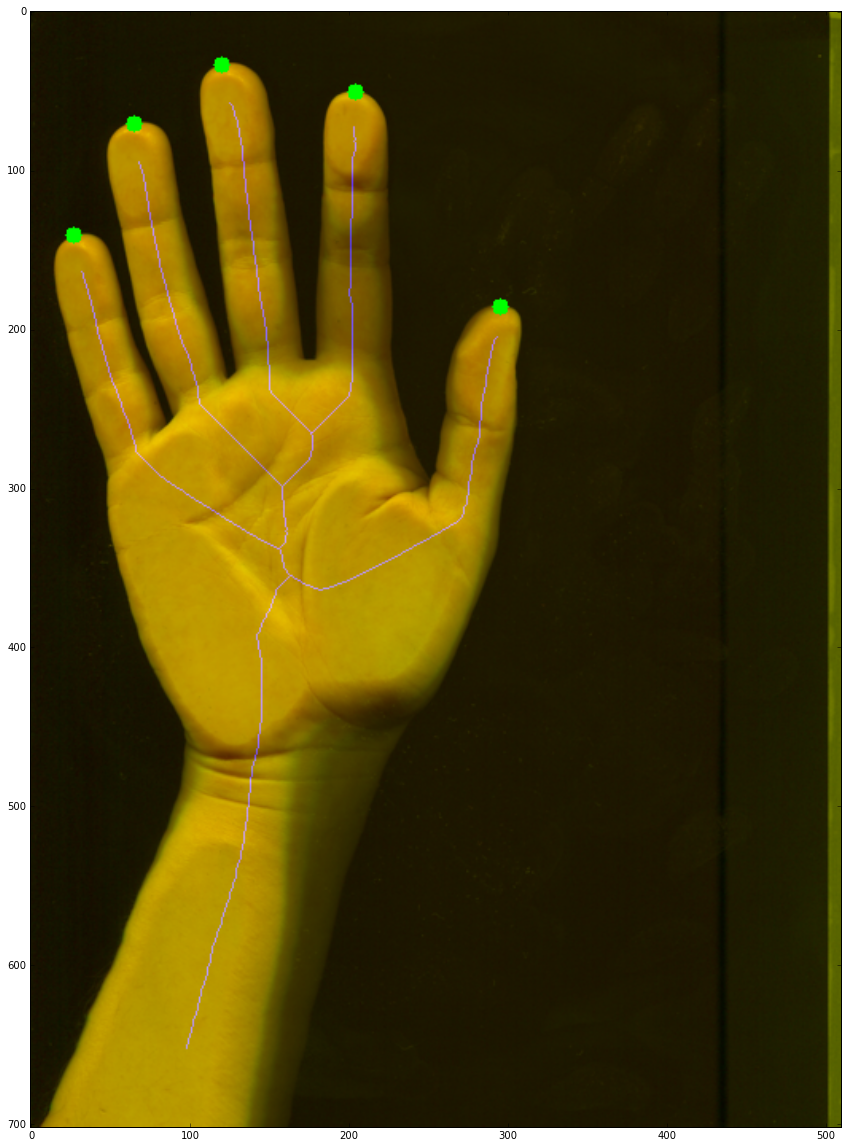

In [34]:
I_tips = I.copy()
tips = list()
for f in ordered_fingers_final:
    path = graph.get_path(graph.connections[tuple(f)][0], tuple(f))
    path_cut = np.array(path[-29:-10]) - np.array(path[-30])
    path_cut = path_cut / np.linalg.norm(path_cut, axis=1).reshape(19, 1)
    avg_direction = np.mean(path_cut, axis=0)
    cur_f = np.array(f).astype(np.float64)
    dx = 2
    prev_f = None
    while True:
        cur_f += avg_direction
        delta = cur_f.astype(np.int)
        if I_b[delta[0], delta[1]] == 0:
            break
        else:
            prev_f = delta
    tips.append(tuple(prev_f.tolist()))
            
for t in tips:
    cv2.circle(I_tips, tuple(t[::-1]), 5, (0,255,0), -1)
    
I_tips[:,:,0] = I_skel * 255
show_big_image(cv2.cvtColor(I_tips, cv2.COLOR_BGR2RGB), size=(40,20))
    
    

Визуализируем искомую ломанную.

[(141, 27), (254, 89), (71, 65), (229, 126), (34, 120), (219, 175), (51, 204), (298, 246), (186, 295)]


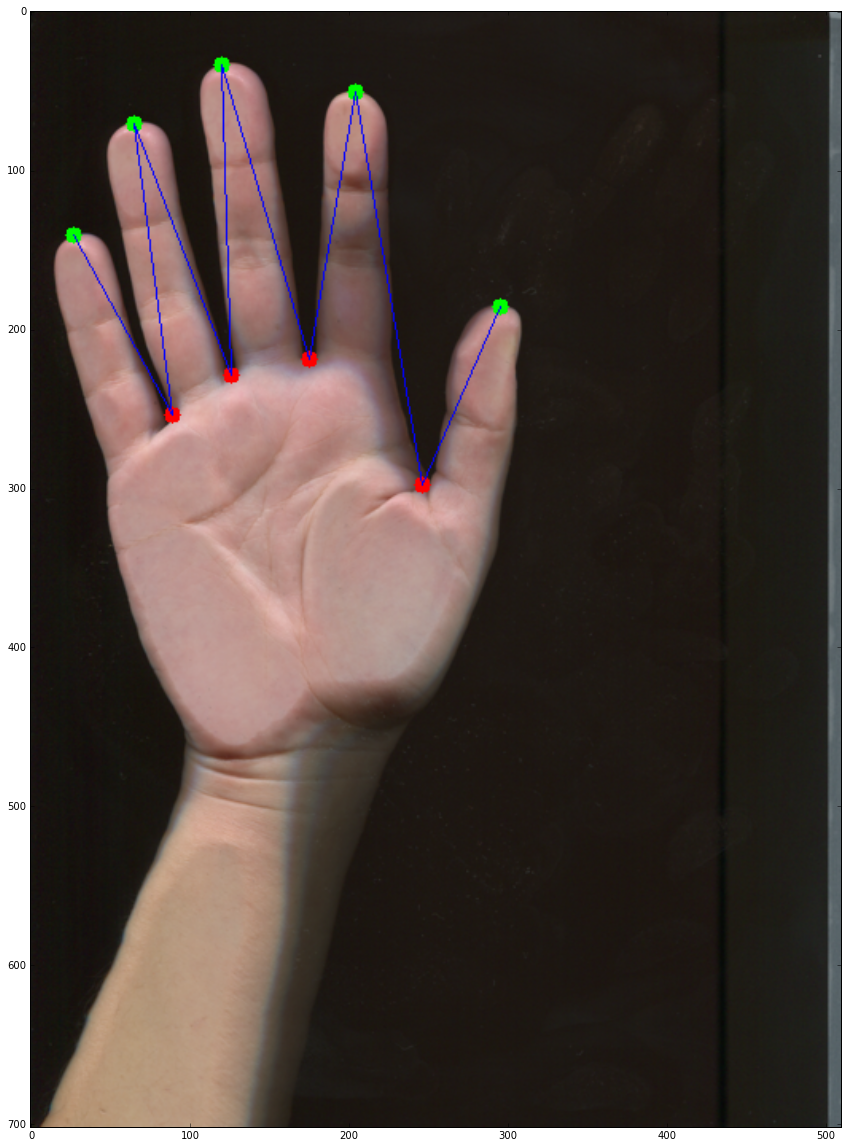

In [35]:
I_final = I.copy()
for v in valleys:
    cv2.circle(I_final, tuple(v[::-1]), 5, (0,0,255), -1)

for t in tips:
    cv2.circle(I_final, tuple(t[::-1]), 5, (0,255,0), -1)
    
line_list = []

for i in range(0, 4):
    line_list.append(tips[i])
    line_list.append(valleys[i])
    
    
line_list.append(tips[-1])
print(line_list)
for i in range(0, len(line_list) - 1):
    p1 = line_list[i]
    p2 = line_list[i + 1]
    cv2.line(I_final, p1[::-1], p2[::-1], (255,0,0), 1)
    
show_big_image(cv2.cvtColor(I_final, cv2.COLOR_BGR2RGB), size=(40,20))

Цель достигнута.

## Результаты 

Запуск данного алгоритма на всех данных можно сделать скриптом run_parallel.py. Успешно выделены признаки для 94 картинок из 99. Не удалось обработать файлы: 013, 138, 096, 012, 111.Причина ошибок заключается в сложности подобрать параметры бинаризации так, чтобы совсем не было дефектов. Эти дефекты приводят к искажению скелета, к которым алгоритм оказывается чувствительным. Посмотреть результаты можно здесь https://drive.google.com/open?id=0B2gwDa2MdyJLRTVZYjBjdzJNRU0.